# Проектный практикум 3. Учебная задача
# Часть 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Краткое описание:**

Создать нейронную сеть, способную генерировать текстовые отзывы о различных местах на основе определенных входных параметров, таких как категория места, средний рейтинг и ключевые слова.

Данные: https://github.com/yandex/geo-reviews-dataset-2023

**Описание датасета**
- 500 000 уникальных отзывов
- Только отзывы на организации в России
- Доступны на Яндекс Картах
- Опубликованы с января по июль 2023 года
- Датасет не содержит коротких односложных отзывов
- Тексты очищены от персональных данных (номеров телефонов, адресов почты)


**Состав датасета**

Датасет в формате tskv содержит следующую информацию:

* Адрес организации (address)
* Название организации (name_ru)
* Список рубрик, к которым относится организация (rubrics)
* Оценка пользователя от 0 до 5 (rating)
* Текст отзыва (text)

## Импорт необходимых библиотек

In [ ]:
!pip install pymorphy2

In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import re
from collections import Counter

from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import numpy as np

import pymorphy2
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.snowball import RussianStemmer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
import string

## Знакомство с данными, базовый анализ и расширение данных

In [ ]:
# Загрузка датасета
dataset = pd.read_parquet("hf://datasets/d0rj/geo-reviews-dataset-2023/data/train-00000-of-00001-49261e4e5a35a5a0.parquet")

In [ ]:
dataset.head()

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...


Для начала очистим датасет от пропуской и дублей

In [ ]:
# Посмотрим на пропуски. Сколько пропущенных значений присутствует в данных
total_missing = dataset.isnull().sum()
print(f"Пропущено \n{total_missing} значений")

Пропущено 
address      0
name_ru    970
rating       0
rubrics      0
text         0
dtype: int64 значений


In [ ]:
# Удаляем пропущенные значения
cleaned_data = dataset.dropna(subset=['name_ru'])
total_missing = cleaned_data.isnull().sum().sum()
print(f" Пропущено {total_missing} значений")

 Пропущено 0 значений


In [ ]:
# Проверяем на дубликаты
duplicates = cleaned_data.duplicated().sum()
print(f" {duplicates} дубликат(ов).")

 1 дубликат(ов).


In [ ]:
# Удаление дубликатов
cleaned_data = cleaned_data.drop_duplicates(subset=['text']).reset_index(drop=True)

duplicates = cleaned_data.duplicated().sum()
print(f" {duplicates} дубликат(ов).")

 0 дубликат(ов).


Посмотрим статистику по адресам, организациям и рубрикам

In [ ]:
# Подсчет количества уникальных организаций по названию
unique_organizations_count = dataset['name_ru'].nunique()

# Вывод результата
print(f'Количество уникальных организаций: {unique_organizations_count}')

Количество уникальных организаций: 148456


In [ ]:
# Подсчет количества уникальных адресов
unique_address_count = dataset['address'].nunique()

# Вывод результата
print(f'Количество уникальных адресов: {unique_address_count}')

Количество уникальных адресов: 191925


In [ ]:
# Подсчет количества уникальных рубрик
unique_rubrics_count = dataset['rubrics'].nunique()

# Вывод результата
print(f'Количество уникальных рубрик: {unique_rubrics_count}')

Количество уникальных рубрик: 31793


Диаграмма количества уникальных организаций, адресов и рубрик

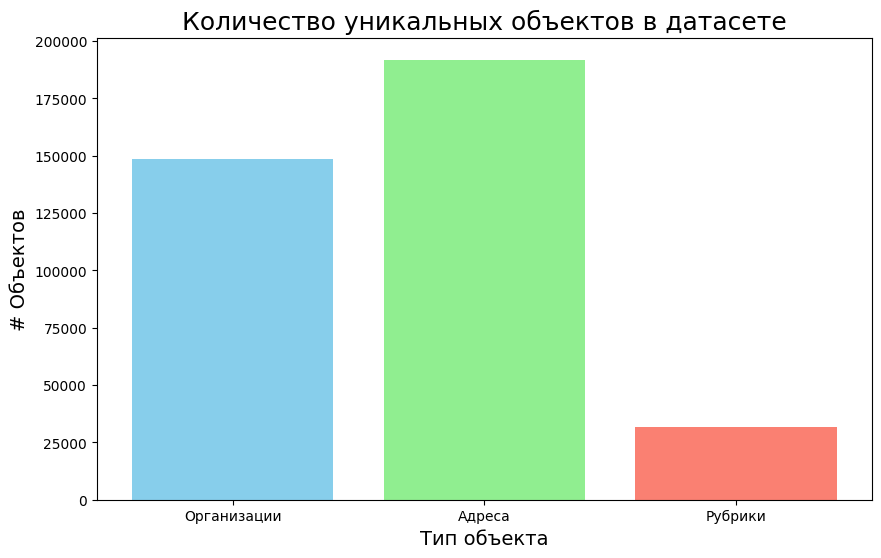

In [ ]:
organizations = len(dataset['name_ru'].unique())
addresses = len(dataset['address'].unique())
rubrics = len(dataset['rubrics'].unique())

# Определение цветов для каждого столбца
colors = ['skyblue', 'lightgreen', 'salmon']

plt.figure(figsize=(10, 6))
plt.bar(['Организации', 'Адреса', 'Рубрики'], [organizations, addresses, rubrics], color=colors)
plt.xlabel('Тип объекта', fontsize=14)
plt.ylabel('# Объектов', fontsize=14)
plt.title('Количество уникальных объектов в датасете', fontsize=18)
plt.show()

Проверим может ли одна организация иметь несколько адресов.

In [ ]:
# Группируем данные по названию организации и считаем уникальные значения адресов
grouped = dataset.groupby(['name_ru'])['address'].nunique()

# Отбираем те строки, где количество уникальных адресов больше 1
organizations_with_multiple_addresses = grouped[grouped > 1]

# Считаем количество таких организаций
count_organizations_with_multiple_addresses = len(organizations_with_multiple_addresses)

print(f"Количество организаций с разными адресами: {count_organizations_with_multiple_addresses}")

Количество организаций с разными адресами: 21523


Видим, чтот в датасете представлены организации, у которых есть филиалы, отделения в разных местах.

Возможно, хорошей идеей было быт кластеризовать организации по адресам.


В процессе работы с данным датасетом была предпринята попытка извлечь долготу и широту с использованием библиотеки geopy и сервиса Nominatim. Это осуществлялось как через API, так и путем развертывания собственного экземпляра Nominatim с использованием Docker.
Попытка испольщовать API для геокодирования адресов оказалась нецелесообразной, так как занимает очень много времни..

Развертывание Nominatim через Docker позволяет избежать ограничений API, однако после развертывания контейнера оказалось, что загрузка файла russia-latest.osm.pbf с российскми адресами может занять несколько дней.

Одним из возможных новых признаков, который можно добавить в ваш датасет, является список ключевых слов, соответствующих каждой рубрике. Это позволит связать каждую организацию с конкретными ключевыми словами, которые характеризуют её деятельность.

In [ ]:
#Инициализируем экземпляр MorphAnalyzer
morph = pymorphy2.MorphAnalyzer(lang='ru')

#Скачаем словарь стоп-слов, который потребуется в функции лемматизации текста
nltk.download('stopwords')
stops = nltk.corpus.stopwords.words('russian')

# Дополним датасет дополнительными стоп-словами
stops.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', 'к', 'на', 'руб', 'мой', 'твой', 'его', 'её', 'наш', 'ваш', 'их', 'свой', 'еще', 'очень', 'поэтому', 'однако', 'конечно'])
unique_stops = set(stops)

# Объявим функцию для лемматизации текста и выделения частей речи
def extract_nouns(text):
    nouns = []

    #Очищаем текст от лишнего
    clean_text = re.sub(r'\s+', ' ', re.sub(r'[\d\W]', ' ', text))

    # Разбиваем текст на слова
    words = clean_text.split()

    for word in words:
        parsed_word = morph.parse(word)[0]

        # Приводим слово к нормальной форме
        normalized_word = parsed_word.normal_form
        if normalized_word not in unique_stops:

            # Определяем часть речи слова
            pos = parsed_word.tag.POS
            case = parsed_word.tag.case
            anim = parsed_word.tag.animacy

            # Выделяем существительные, но отфильтровываем имена собственные
            if pos == 'NOUN' and not (case == 'nomn' and anim == 'anim'):
                nouns.append(normalized_word)

    return ' '.join(nouns)

# Добавим в датасет колонку с обработанным текстом
dataset['aspects'] = dataset['text'].apply(extract_nouns)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Теперь мы можем выделить ключевые слова для каждой рубрики с помощью TF‑IDF‑анализа.

In [ ]:
# Объявим функцию для обработки текстов и сохранения результата анализа
def find_top_words_by_rubric(vectorizer):
    result = {
        'rubrics': [],
        'words': [],
        'reviews': [],
        'scores': []
    }

    # Проходимся по рубрикам
    for rubric in df_flattened['rubrics'].unique():
        texts = df_flattened[df_flattened['rubrics'] == rubric]['aspects']
        total_count = texts.shape[0]

        # В анализ возьмём только те рубрики, у которых есть несколько текстов
        if total_count >= 5:
            tfidf_matrix = vectorizer.fit_transform(texts)
        else:
            continue

        result['rubrics'].append(rubric)
        result['reviews'].append(total_count)
        feature_names = vectorizer.get_feature_names_out()  # Исправлено здесь
        tfidf_scores = tfidf_matrix.max(axis=0).toarray().ravel()

        # Возьмём топ-20 слов для каждой рубрики
        top_words_indices = tfidf_scores.argsort()[-20:][::-1]
        top_words = [feature_names[i] for i in top_words_indices]
        result['words'].append(', '.join(top_words))
        top_scores = [str(tfidf_scores[i]) for i in top_words_indices]
        result['scores'].append(', '.join(top_scores))

    return result

# Развернём датасет по рубрикам, так как одна организация может принадлежать к списку рубрик
# Убедитесь, что 'rubrics' содержит строки, а не списки
dataset['rubrics'] = dataset['rubrics'].apply(lambda x: x.split(";") if isinstance(x, str) else x)
df_flattened = dataset.explode('rubrics')

# Инициализируем TF-IDF-векторизатор
aspects_vectorizer = TfidfVectorizer(use_idf=True, max_df=0.8, min_df=0.1)

# Создадим датафрейм с результатами анализа
tf_idf_aspects = pd.DataFrame(find_top_words_by_rubric(aspects_vectorizer)).sort_values(by='reviews', ascending=False)

In [ ]:
tf_idf_aspects.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1244 entries, 13 to 1177
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   rubrics  1244 non-null   object
 1   words    1244 non-null   object
 2   reviews  1244 non-null   int64 
 3   scores   1244 non-null   object
dtypes: int64(1), object(3)
memory usage: 48.6+ KB


В результате мы видим, что выделяются слова, которые неплохо характеризуют рубрику. Например, для магазинов выделяется «ассортимент», для ресторанов — «атмосфера», а для рубрик, связанных с предоставлением услуг, — «мастер».

In [ ]:
tf_idf_aspects.head(30)

,rubrics,words,reviews,scores
13,Кафе,"цена, персонал, обслуживание, место, меню, кух...",58496,"1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1..."
22,Ресторан,"цена, ресторан, персонал, обслуживание, музыка...",56761,"1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1..."
25,Гостиница,"этаж, место, вид, вода, гостиница, день, еда, ...",43133,"1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1..."
1,Магазин продуктов,"цена, товар, продукт, персонал, магазин, касса...",21346,"1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0"
46,Супермаркет,"цена, товар, продукт, персонал, очередь, магаз...",19746,"1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0"
65,"Бар, паб","цена, пиво, персонал, обслуживание, напиток, м...",19238,"1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1..."
8,Салон красоты,"студия, стрижка, салон, результат, работа, про...",17910,"1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1..."
26,Быстрое питание,"шаурм, цена, персонал, место, заказ, заведение...",16859,"1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0"
27,Доставка еды и обедов,"цена, ролл, ресторан, пицца, персонал, обслужи...",14394,"1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1..."
36,Ногтевая студия,"студия, стрижка, салон, работа, персонал, педи...",11649,"1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1..."


In [ ]:
# Сохранение в CSV файл
tf_idf_aspects.to_csv('/content/drive/MyDrive/Проектный практикум 3/tf_idf_aspects.csv', index=False)

Теперь у нас есть датасет с с  ключевыми словами по каждой рубрике.

In [ ]:
#  Загрузка данных
tf_idf_aspects = pd.read_csv('/content/drive/MyDrive/Проектный практикум 3/tf_idf_aspects.csv')

In [ ]:
tf_idf_aspects.head(5)

,rubrics,words,reviews,scores
0,Кафе,"цена, персонал, обслуживание, место, меню, кух...",58496,"1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1..."
1,Ресторан,"цена, ресторан, персонал, обслуживание, музыка...",56761,"1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1..."
2,Гостиница,"этаж, место, вид, вода, гостиница, день, еда, ...",43133,"1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1..."
3,Магазин продуктов,"цена, товар, продукт, персонал, магазин, касса...",21346,"1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0"
4,Супермаркет,"цена, товар, продукт, персонал, очередь, магаз...",19746,"1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0"


In [ ]:
df_keywords = tf_idf_aspects.set_index('rubrics').to_dict()['words']

In [ ]:
# Функция для объединения ключевых слов по рубрикам
def get_keywords_for_rubrics(rubrics):
    keywords_list = []
    for rubric in rubrics.split(';'):
        index = tf_idf_aspects['rubrics'] == rubric.strip()
        rows = tf_idf_aspects[index]['words']
        if len(rows) > 0:
            keywords = rows.values[0]
            keywords_list.append(keywords)
    return keywords_list

In [ ]:
def get_keywords_for_rubrics(rubrics):
    keywords_list = []
    for rubric in rubrics.split(';'):
        index = tf_idf_aspects['rubrics'] == rubric.strip()
        rows = tf_idf_aspects[index]['words']
        if len(rows) > 0:
            keywords = rows.values[0]
            keywords_list.append(keywords)

    # Преобразуем список в строку, разделённую запятыми
    result_string = ', '.join(keywords_list)

    return result_string

In [ ]:
# Добавляем новый столбец с ключевыми словами
dataset['kw_by_rub'] = dataset['rubrics'].apply(get_keywords_for_rubrics)

In [ ]:
dataset.head(5)

,address,name_ru,rating,rubrics,text,kw_by_rub
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...,"школа, магазин, город, двор, дом, доступность,..."
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ...","цена, товар, продукт, персонал, магазин, касса..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я...","цена, место, бассейн, время, год, зал, занятие..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...,"эмоция, цена, прокат, персонал, место, маршрут..."
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...,"студия, стрижка, салон, результат, работа, про..."


In [ ]:
print(f"Организация: {dataset['name_ru'][5]}")
print(f"Ключевые слова: {dataset['kw_by_rub'][5]}")

Организация: Tele2
Ключевые слова: услуга, телефон, тариф, связь, салон, проблема, офис, оператор, номер, карта, итог, интернет, деньга, день, год, вопрос, цена, обслуживание, время, год, день, интернет, качество, компания, месяц, поддержка, услуга, проблема, провайдер, работа, связь, скорость, тариф, телефон, вопрос


Диаграмма ключевых слов по рубрикам

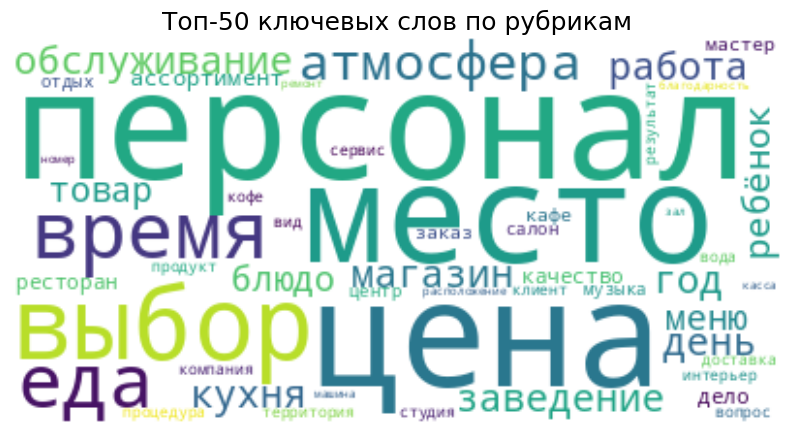

In [ ]:
# Преобразование строк в список слов и подсчет частоты
keywords = dataset['kw_by_rub'].str.cat(sep=', ').split(', ')
keyword_counts = pd.Series(keywords).value_counts()[:50]  # Топ-30 слов

# Генерация облака слов
wc = WordCloud(background_color="white", max_words=50).generate_from_frequencies(keyword_counts)

# Настройка отображения графиков
%matplotlib inline

# Построение графика
plt.figure(figsize=(10, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Топ-50 ключевых слов по рубрикам', fontsize=18)
plt.show()

Таким образом мы расширили датасет новым признаком - ключевые слова по набору рубрук ('kw_by_rub').

In [ ]:
# Сохранение в CSV файл
dataset.to_csv('/content/drive/MyDrive/Проектный практикум 3/dataset_kw_rub.csv', index=False)

Посмотрим распределение организаций по рейтингу

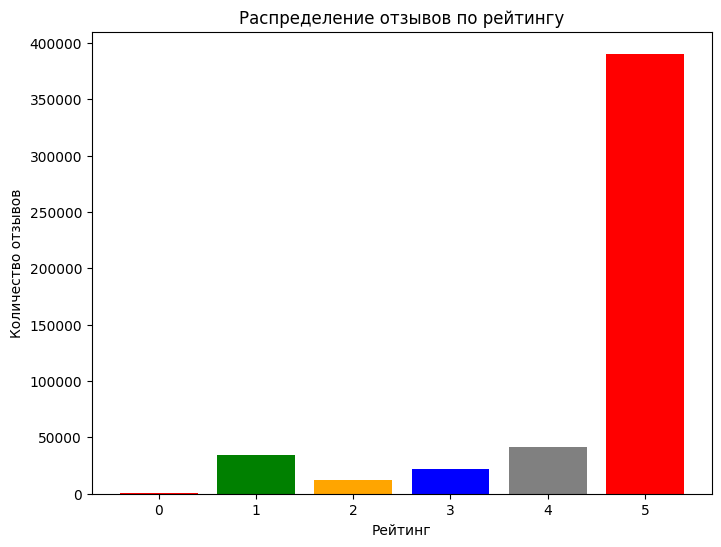

In [ ]:
# Подсчет количества по рейтингу
counts = dataset['rating'].value_counts()

# Построение графика
plt.figure(figsize=(8, 6))
plt.bar(counts.index, counts.values, color=['red', 'gray', 'green', 'blue', 'orange'])
plt.title('Распределение отзывов по рейтингу')
plt.xlabel('Рейтинг')
plt.ylabel('Количество отзывов')
plt.show()

Наблюдаем сильный дисбалланс в сторону рейтинга "5"

Заменим рейтинг средним рейтингом организации

In [ ]:
# Вычисление среднего рейтинга для каждой организации
average_ratings = dataset.groupby('name_ru')['rating'].mean().reset_index()

# Переименуем столбец со средним рейтингом
average_ratings.rename(columns={'rating': 'average_rating'}, inplace=True)

# Объединяем средние рейтинги с исходным датасетом
dataset = dataset.merge(average_ratings, on='name_ru', how='left').round(1)


In [ ]:
dataset.head()

,address,name_ru,rating,rubrics,text,kw_by_rub,average_rating
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...,"школа, магазин, город, двор, дом, доступность,...",3.0
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ...","цена, товар, продукт, персонал, магазин, касса...",4.5
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я...","цена, место, бассейн, время, год, зал, занятие...",1.0
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...,"эмоция, цена, прокат, персонал, место, маршрут...",4.0
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...,"студия, стрижка, салон, результат, работа, про...",5.0


In [ ]:
# Сохранение в CSV файл
# dataset.to_csv('/content/drive/MyDrive/Проектный практикум 3/dataset_kw_rub_avr_rat.csv', index=False)

In [ ]:
#  Загрузка данных
dataset = pd.read_csv('/content/drive/MyDrive/Проектный практикум 3/dataset_kw_rub_avr_rat.csv')

In [ ]:
dataset.head()

,address,name_ru,rating,rubrics,text,kw_by_rub,average_rating
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...,"школа, магазин, город, двор, дом, доступность,...",3.0
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ...","цена, товар, продукт, персонал, магазин, касса...",4.5
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я...","цена, место, бассейн, время, год, зал, занятие...",1.0
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...,"эмоция, цена, прокат, персонал, место, маршрут...",4.0
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...,"студия, стрижка, салон, результат, работа, про...",5.0


Проведем базовую очистку текстов отзывов

In [ ]:
# Предварительной обработки текста
def clean_text(text):
    # Приведение к нижнему регистру
    text = text.lower()

    # Удаление HTML-тегов (если есть)
    text = re.sub(r'<[^>]+>', '', text)

    # Удаление символов переноса
    text = text.replace('\n', ' ')

    # Удаление буквы 'n'
    text = text.replace('n', '')

    # Удаление нежелательных символов, сохраняя базовую пунктуацию
    text = re.sub(r'[^\w\s\.-]', '', text)

    # Удаление цифр
    text = re.sub(r'\d+', '', text)

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()

    # Замена нескольких точек на одну
    text = re.sub(r'\.{2,}', '.', text)

    # Добавление пробела после точки
    text = re.sub(r'\.', '. ', text)

    # Убираем пробел перед точкой
    text = re.sub(r' \.', '.', text)

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
# Применение функции clean_text к каждому элементу столбца 'text'
dataset['text'] = dataset['text'].apply(clean_text)

In [ ]:
dataset['text'][2]

'не знаю смутят ли кого-то данные правила но я была удивлена. хочешь что бы твой шкаф замыкался - купи замочек. ты должен предоставить свой отпечаток пальца полнейшая дичь. ставят подпись на договоре с клиентом по доверенности графу с номером доверенности оставляют пустой а на вопрос о номере доверенности говорят номер вы серьезно номер предоставить доверенность не могут но говорят что у них в клубе свои доверенности типа особенные какие-то цирк.'

In [ ]:
dataset.head()

,address,name_ru,rating,rubrics,text,kw_by_rub,average_rating
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3,Жилой комплекс,московский квартал. шумно летом по ночам дикие...,"школа, магазин, город, двор, дом, доступность,...",3.0
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5,Магазин продуктов;Продукты глубокой заморозки;...,замечательная сеть магазинов в общем хороший а...,"цена, товар, продукт, персонал, магазин, касса...",4.5
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1,Фитнес-клуб,не знаю смутят ли кого-то данные правила но я ...,"цена, место, бассейн, время, год, зал, занятие...",1.0
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4,Пункт проката;Прокат велосипедов;Сапсёрфинг,хорошие условия аренды. дружелюбный персонал. ...,"эмоция, цена, прокат, персонал, место, маршрут...",4.0
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5,"Салон красоты;Визажисты, стилисты;Салон бровей...",топ мастер ангелина топ во всех смыслах немног...,"студия, стрижка, салон, результат, работа, про...",5.0


In [ ]:
# Сохранение в CSV файл
dataset.to_csv('/content/drive/MyDrive/Проектный практикум 3/dataset_preprocessed.csv', index=False)